<a href="https://colab.research.google.com/github/rinshankolayil/Python/blob/master/Retraining_an_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np

In [6]:
print(tf.__version__)
print(hub.__version__)
print("GPU is", f"AVAILABLE{tf.config.list_physical_devices('GPU')}" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2.8.2
0.12.0
GPU is AVAILABLE[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [8]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [9]:
data_dir = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True
)

228827136/228813984 [==============================] - 1s 0us/step


In [12]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset=subset,label_mode='categorical',seed=123,image_size=IMAGE_SIZE,batch_size=1)
  

In [36]:
train_ds = build_dataset('training')
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [39]:
normalization_layer  = tf.keras.layers.Rescaling(1.0/255)
preprocessing_model  = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
  preprocessing_model.add(tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2,0))
  preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(tf.keras.layers.RandomFlip(mode='horizontal'))
train_ds = train_ds.map(lambda images,labels:(preprocessing_model(images),labels))

In [40]:
val_ds = build_dataset('validation')
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images,labels: (normalization_layer(images),labels))

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [42]:
do_fine_tuning = False
print("Building model with", model_handle)

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE+(3,)),
    hub.KerasLayer(model_handle,trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

In [46]:
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005,momentum=0.9),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,label_smoothing=0.1),
    metrics=['accuracy']
  )


In [49]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(train_ds,epochs=5,steps_per_epoch=steps_per_epoch,validation_data=val_ds,validation_steps=validation_steps).history

Epoch 1/5
183/183 [==============================] - 22s 48ms/step - loss: 0.8962 - accuracy: 0.7831 - val_loss: 0.6870 - val_accuracy: 0.8792
Epoch 2/5
183/183 [==============================] - 9s 46ms/step - loss: 0.7127 - accuracy: 0.8760 - val_loss: 0.6723 - val_accuracy: 0.8986
Epoch 3/5
183/183 [==============================] - 8s 46ms/step - loss: 0.6641 - accuracy: 0.8979 - val_loss: 0.6658 - val_accuracy: 0.9056
Epoch 4/5
183/183 [==============================] - 8s 45ms/step - loss: 0.6401 - accuracy: 0.9113 - val_loss: 0.6585 - val_accuracy: 0.8944
Epoch 5/5
183/183 [==============================] - 8s 46ms/step - loss: 0.6177 - accuracy: 0.9229 - val_loss: 0.7026 - val_accuracy: 0.8833


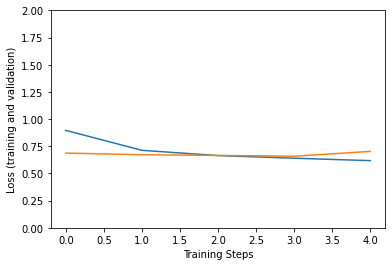

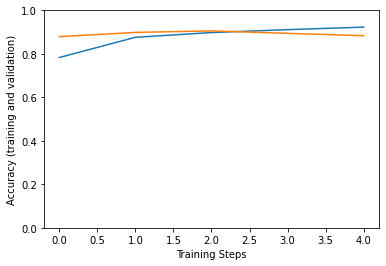

In [50]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [58]:
x,y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])

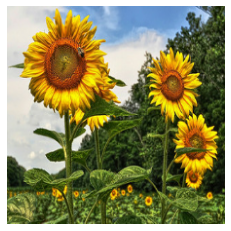

In [59]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [69]:
im = np.expand_dims(image, axis=0)
print(im.shape)

(1, 224, 224, 3)


In [66]:
prediction_scores = model.predict(im)

In [67]:
redicted_index = np.argmax(prediction_scores)

In [68]:
print("True label: " + class_names[true_index])

True label: sunflowers


In [92]:
from urllib import request
from io import BytesIO
from PIL import Image
def get_pred(path):
    res = request.urlopen(path).read()
    test_img = np.asarray(Image.open(BytesIO(res)).resize((224,224)))
    test_img = test_img / 255
    x = test_img
    test_img = np.expand_dims(test_img, axis=0)
    prediction_scores = model.predict(test_img)
    plt.title("True label: " + class_names[np.argmax(prediction_scores)])
    plt.imshow(x)
    plt.show()

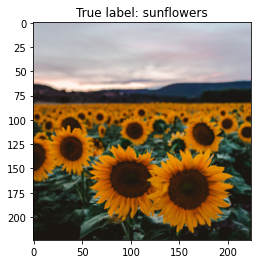

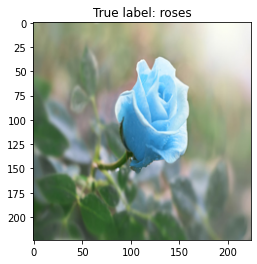

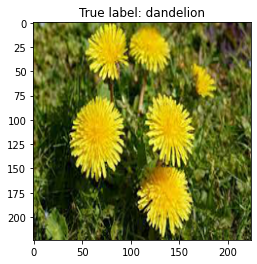

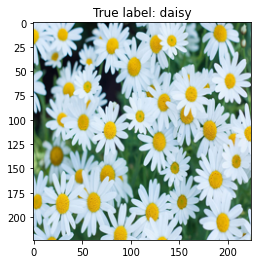

In [96]:
url = ['https://images.theconversation.com/files/447129/original/file-20220217-6550-1my6qii.jpg?ixlib=rb-1.1.0&q=45&auto=format&w=1200&h=1200.0&fit=crop',
       'https://res.cloudinary.com/interflora/f_auto,q_auto,t_blogimage/blogs/blue%20rose1569237015449.jpg',
       'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQns0yx26jbIoZasgD_EilO56tWsoqxEehlwYeXil0jUy6NjaazrHSKi2XzkIWzKaJw6nA&usqp=CAU',
       'https://cdn.britannica.com/36/82536-050-7E968918/Shasta-daisies.jpg'
      ]
for u in url:
  get_pred(u)